# Kaggle competition - FGVC11 Plant Traits 2024

### Install necesssary dependencies

In [1]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

### Import Libraries

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import math
import keras_cv
from tensorflow import keras
from keras import ops
import tensorflow as tf
from tensorflow.keras import ops

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

from sklearn.model_selection import StratifiedKFold

2024-04-24 17:59:28.508564: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 17:59:28.508620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 17:59:28.510026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Configurations

In [3]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "/kaggle/input/efficientnetv2/keras/efficientnetv2_b2_imagenet/3"  # Name of pretrained classifier
    image_size = [200, 200]  # Input image size
    epochs = 10 # Training epochs
    batch_size = 64  # Batch size
    lr_mode = "step" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

Set Seed for reproducability

In [4]:
keras.utils.set_random_seed(CFG.seed)

### Import the Dataset

In [5]:
DATA_PATH = "/kaggle/input/planttraits2024"

### Meta Data

In this dataset, we have information on 6 different plant traits. Here, plant trait refers to various characteristics or features of plants, such as leaf area or plant height. In this competition, we aim to predict the average of these traits, indicated as X[*]_mean, for each species.  The description of each trait can be found in the table below:

* X4 : Stem specific density (SSD) or wood density 
* X11 : Leaf area per leaf dry mass
* X18 : Plant height
* X26 : Seed dry mass
* X50 : Leaf nitrogen (N) content per leaf area
* X3112 : Leaf area 


In [6]:
# train
df = pd.read_csv(f'{DATA_PATH}/train.csv')
df['image_path'] = f'{DATA_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head())

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  192027691                               12.235703   
1  195542235                               17.270555   
2  196639184                               14.254504   
3  195728812                               18.680834   
4  195251545                                0.673204   

   WORLDCLIM_BIO12_annual_precipitation  \
0                            374.466675   
1                             90.239998   
2                            902.071411   
3                           1473.933350   
4                            530.088867   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                          62.524445                       
1                                          10.351111                       
2                                          49.642857                       
3                                         163.100006                       
4                                          50.857777                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  72.256844   
1                                  38.220940   
2                                  17.873655   
3                                  45.009758   
4                                  38.230709   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              773.592041   
1                              859.193298   
2                              387.977753   
3                              381.053986   
4                             1323.526855   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                33.277779                            125   
1                                40.009777                            124   
2                                22.807142                            107   
3                                20.436666                            120   
4                                45.891998                             91   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                149                              136  ...   
1                                144                              138  ...   
2                                133                              119  ...   
3                                131                              125  ...   
4                                146                              120  ...   

    X26_mean  X50_mean   X3112_mean     X4_sd    X11_sd    X18_sd    X26_sd  \
0   1.243779  1.849375    50.216034  0.008921  1.601473  0.025441  0.153608   
1   0.642940  1.353468   574.098472  0.003102  0.258078  0.000866  0.034630   
2   0.395241  2.343153  1130.096731 -1.000000 -1.000000 -1.000000 -1.000000   
3   0.154200  1.155308  1042.686546  0.011692  2.818356  0.110673  0.011334   
4  10.919966  2.246226  2386.467180  0.006157  1.128000  0.026996  0.553815   

     X50_sd    X3112_sd                                         image_path  
0  0.279610   15.045054  /kaggle/input/planttraits2024/train_images/192...  
1  0.010165   11.004477  /kaggle/input/planttraits2024/train_images/195...  
2 -1.000000   -1.000000  /kaggle/input/planttraits2024/train_images/196...  
3  0.229224  141.857187  /kaggle/input/planttraits2024/train_images/195...  
4  0.107092   87.146899  /kaggle/input/planttraits2024/train_images/195...  

[5 rows x 177 columns]

In [7]:
# Test
test_df = pd.read_csv(f'{DATA_PATH}/test.csv')
test_df['image_path'] = f'{DATA_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head())

id  WORLDCLIM_BIO1_annual_mean_temperature  \
0  201238668                                8.086756   
1  202310319                               10.844286   
2  202604412                                8.105556   
3  201353439                                7.077679   
4  195351745                                4.790555   

   WORLDCLIM_BIO12_annual_precipitation  \
0                           2246.500000   
1                            495.871429   
2                            378.328583   
3                            878.785706   
4                           2299.366699   

   WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month  \
0                                         127.321426                       
1                                          28.023809                       
2                                          39.928570                       
3                                          70.428574                       
4                                         150.199997                       

   WORLDCLIM_BIO15_precipitation_seasonality  \
0                                  20.423418   
1                                  18.738306   
2                                  41.885647   
3                                  37.045235   
4                                  24.136568   

   WORLDCLIM_BIO4_temperature_seasonality  \
0                              353.381042   
1                              786.554382   
2                              722.071167   
3                              669.389343   
4                              462.887695   

   WORLDCLIM_BIO7_temperature_annual_range  SOIL_bdod_0.5cm_mean_0.01_deg  \
0                                17.535713                             80   
1                                29.292856                            130   
2                                34.853809                            133   
3                                25.150000                            103   
4                                22.516666                             85   

   SOIL_bdod_100.200cm_mean_0.01_deg  SOIL_bdod_15.30cm_mean_0.01_deg  ...  \
0                                109                               90  ...   
1                                155                              142  ...   
2                                134                              139  ...   
3                                140                              116  ...   
4                                114                               98  ...   

   VOD_X_1997_2018_multiyear_mean_m04  VOD_X_1997_2018_multiyear_mean_m05  \
0                            0.389460                            0.387536   
1                            0.300813                            0.332776   
2                            0.418509                            0.437172   
3                            0.313667                            0.352311   
4                            0.506952                            0.462181   

   VOD_X_1997_2018_multiyear_mean_m06  VOD_X_1997_2018_multiyear_mean_m07  \
0                            0.374910                            0.363712   
1                            0.314386                            0.291168   
2                            0.453239                            0.445230   
3                            0.401131                            0.513455   
4                            0.397052                            0.358262   

   VOD_X_1997_2018_multiyear_mean_m08  VOD_X_1997_2018_multiyear_mean_m09  \
0                            0.364623                            0.379435   
1                            0.280947                            0.277623   
2                            0.435441                            0.432758   
3                            0.519174                            0.474007   
4                            0.369279                            0.414420   

   VOD_X_1997_2018_multiyear_mean_m10  VOD_X_1997_2018_multiyear_mean_m11  \

### Load Image data

Load the images from the metadata and applying preprocessing and augmentaion

In [8]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.45, 0.55)),
        keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomCutout(height_factor=(0.03, 0.15), width_factor=(0.06, 0.15)),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras_cv.layers.RandomContrast(factor=0.5, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.05, 0.55)),
        keras_cv.layers.RandomHue(factor=0.3, value_range=(0, 3)),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        path = inp["images"]
        
        # Read jpeg image
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, labels=None):
        inp = decode_image(inp)
        label = decode_label(labels[0], CFG.num_classes)
        aux_label = decode_label(labels[1], CFG.aux_num_classes)
        return (inp, (label, aux_label))

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=False,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None or aux_labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    inp = {"images": paths, "features": features}
    slices = (inp, (labels, aux_labels)) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In the following code, we will split the data into 5 stratified folds. It first creates bins based on 6 plant traits distributions and combines them into a final bin column. Then, it uses this bin for balancing similar traits distributions across all folds.

In [9]:

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


### Splitting the dataset into Train and Val split

In [10]:
from sklearn.preprocessing import StandardScaler

# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Train
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

# Num Train: 44391 | Num Valid: 11098


### Visualizing sample train images

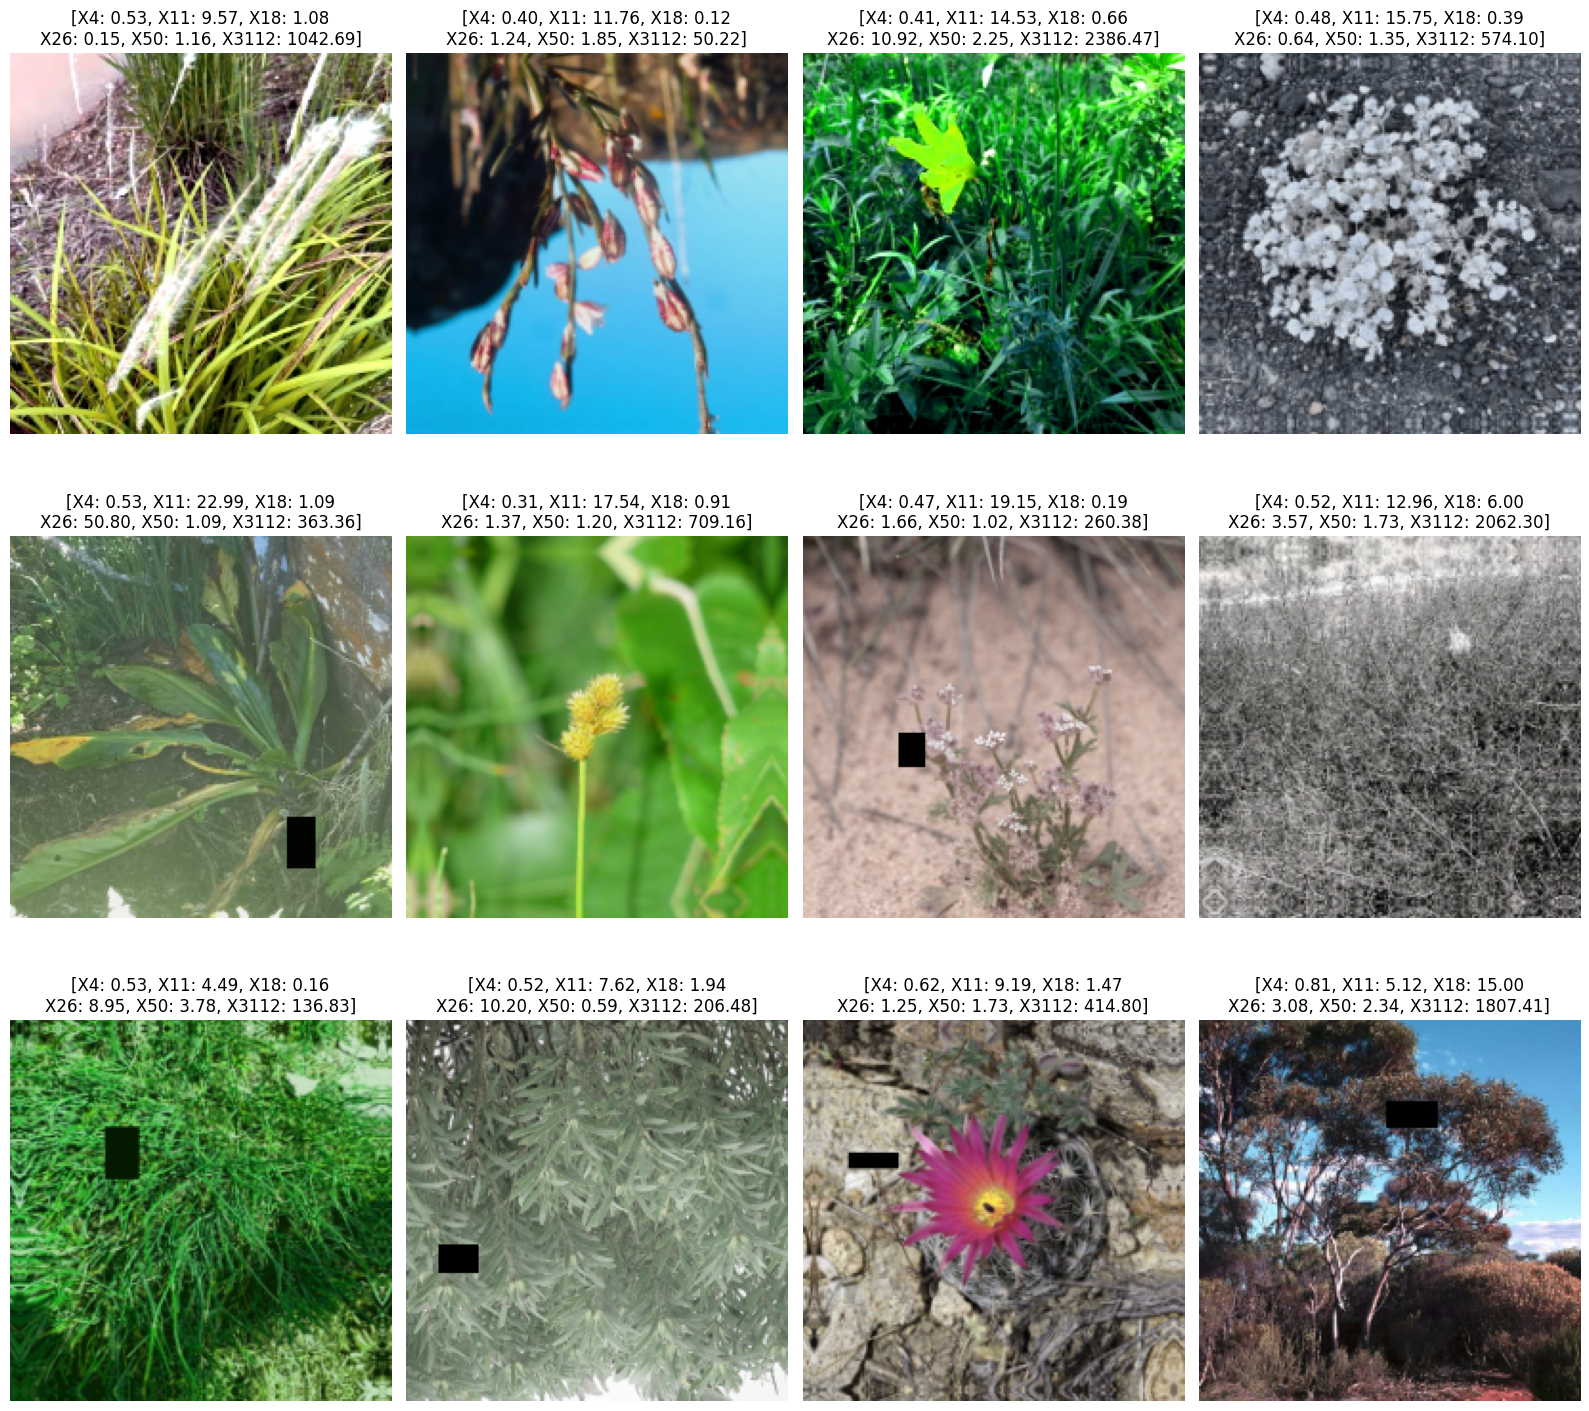

In [11]:
inps, tars = next(iter(train_ds))
imgs = inps["images"]
num_imgs, num_cols = 12, 4

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[:num_imgs], tars[0][:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)
    img = img. numpy()
    tar = tar.numpy()
    
    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Evaluation metrics

In [12]:
class R2Loss(keras.losses.Loss):
    def __init__(self, use_mask=False, name="r2_loss"):
        super().__init__(name=name)
        self.use_mask = use_mask

    def call(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = ops.where(mask, y_true, 0.0)
            y_pred = ops.where(mask, y_pred, 0.0)
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)  # (B, C) -> (C,)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return ops.mean(r2_loss)  # ()
    
class R2Metric(keras.metrics.Metric):
    def __init__(self, name="r2", **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.SS_res = self.add_weight(name='SS_res', shape=(6,), initializer='zeros')
        self.SS_tot = self.add_weight(name='SS_tot', shape=(6,) ,initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)
        self.SS_res.assign_add(SS_res)
        self.SS_tot.assign_add(SS_tot)
        self.num_samples.assign_add(ops.cast(ops.shape(y_true)[0], "float32"))

    def result(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return ops.mean(r2)

    def reset_states(self):
        self.total_SS_res.assign(0)
        self.total_SS_tot.assign(0)
        self.num_samples.assign(0)

### Build the model

In [13]:
from tensorflow import keras
import keras_cv.models

# Define input layers
img_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(len(FEATURE_COLS),), name="features")

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(img_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.5)(x1)
x1 = keras.layers.Dense(512, activation="relu")(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dropout(0.3)(x1)
x1 = keras.layers.Dense(256, activation="relu")(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dropout(0.2)(x1)
x1 = keras.layers.Dense(128, activation="relu")(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dropout(0.1)(x1) 

# Branch for tabular/feature input
x2 = keras.layers.Dense(512, activation="relu")(feat_input) 
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dropout(0.4)(x2) 
x2 = keras.layers.Dense(256, activation="relu")(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dropout(0.2)(x2)  
x2 = keras.layers.Dense(128, activation="relu")(x2)
x2 = keras.layers.BatchNormalization()(x2)
x2 = keras.layers.Dropout(0.1)(x2) 

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out1 = keras.layers.Dense(CFG.num_classes, activation="softmax", name="head")(concat)
out2 = keras.layers.Dense(CFG.aux_num_classes, activation="relu", name="aux_head")(concat)
out = {"head": out1, "aux_head": out2}

# Build model
model = keras.models.Model([img_input, feat_input], out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={  "head": R2Loss(use_mask=False),
        "aux_head": R2Loss(use_mask=True), }, 
    loss_weights={"head": 1.0, "aux_head": 0.3},
    metrics={"head":  R2Metric()},  
)

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 200, 200,  │       0 │ -                    │
│                     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ efficient_net_v2b2… │ (None, 7, 7,      │ 8,769,… │ images[0][0]         │
│ (EfficientNetV2Bac… │ 1408)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 1408)      │       0 │ efficient_net_v2b2_… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │       0 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ features            │ (None, 163)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 512)       │ 721,408 │ dropout[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │  83,968 │ features[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 512)       │   2,048 │ dense[0][0]          │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 512)       │   2,048 │ dense_3[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │       0 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │       0 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │ 131,328 │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │ 131,328 │ dropout_4[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256)       │   1,024 │ dense_1[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 256)       │   1,024 │ dense_4[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │       0 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │       0 │ batch_normalization… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  32,896 │ dropout_2[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │  32,896 │ dropout_5[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 128)       │     512 │ dense_2[0][0]        │
│ (BatchNormalizatio… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼────────────────────

 Total params: 9,913,450 (37.82 MB)

 Trainable params: 9,827,578 (37.49 MB)

 Non-trainable params: 85,872 (335.44 KB)

Model archietecture

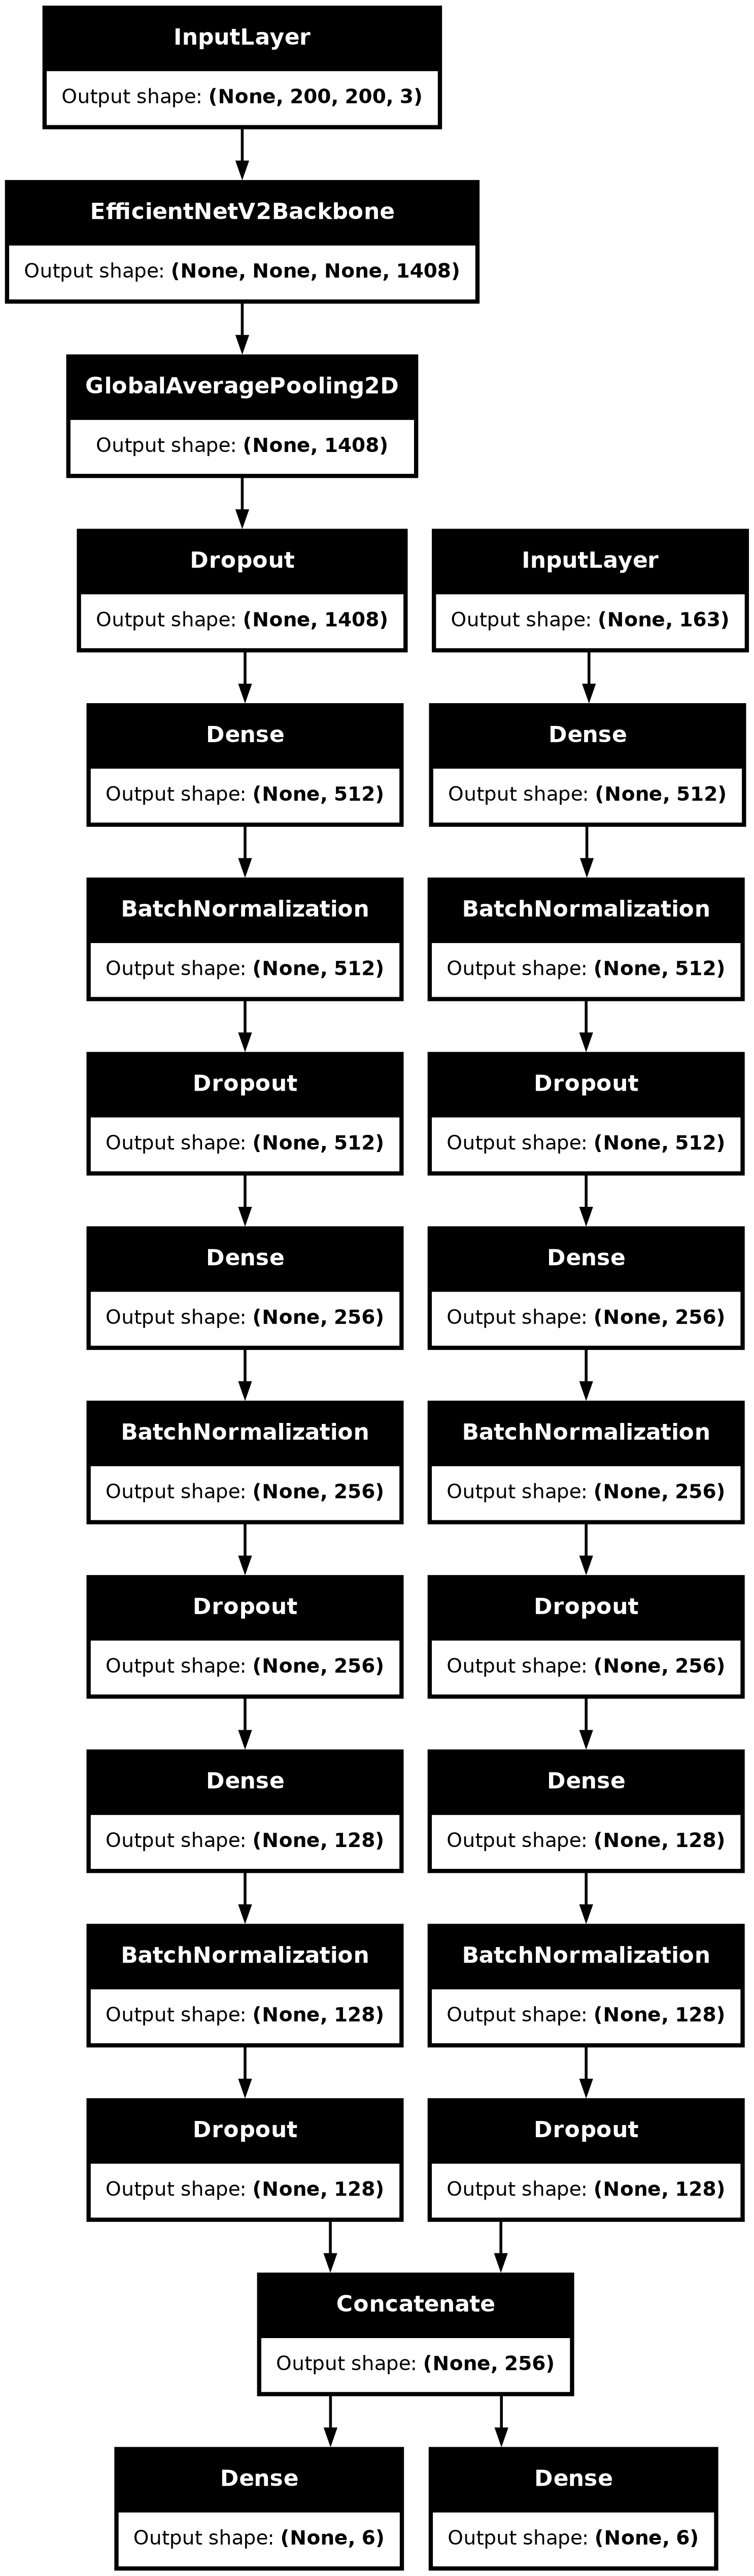

In [14]:
keras.utils.plot_model(model, show_shapes=True)

#### LR Scheduler

In [15]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

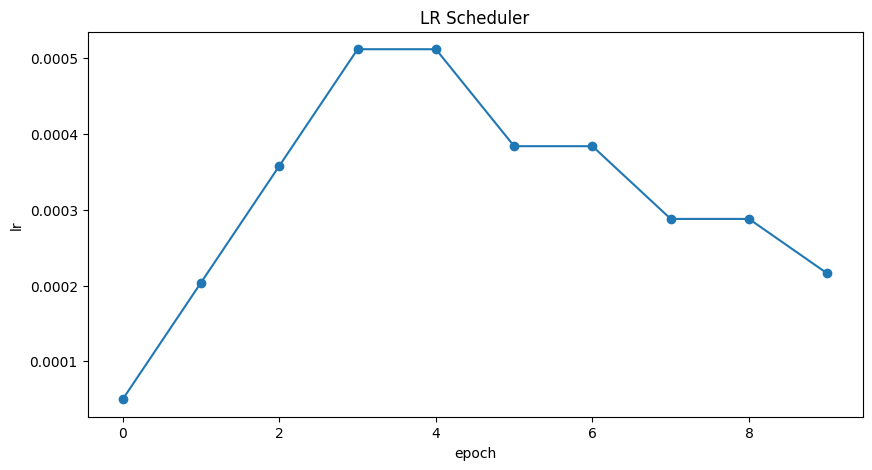

In [16]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

#### Model Checkpoint

In [17]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_head_r2",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

### Training

In [18]:
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_data=valid_ds,
    verbose=CFG.verbose,
)

Epoch 1/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 551s 709ms/step - head_r2: -0.3218 - loss: 3.0650 - val_head_r2: -0.2261 - val_loss: 2.3119 - learning_rate: 5.0000e-05
Epoch 2/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 431s 622ms/step - head_r2: -0.2003 - loss: 2.3809 - val_head_r2: -0.1282 - val_loss: 1.8852 - learning_rate: 2.0400e-04
Epoch 3/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 433s 626ms/step - head_r2: -0.1307 - loss: 2.0425 - val_head_r2: -0.1151 - val_loss: 1.5967 - learning_rate: 3.5800e-04
Epoch 4/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 436s 630ms/step - head_r2: -0.1216 - loss: 1.6495 - val_head_r2: -0.1119 - val_loss: 1.4654 - learning_rate: 5.1200e-04
Epoch 5/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 425s 614ms/step - head_r2: -0.1198 - loss: 1.4984 - val_head_r2: -0.1107 - val_loss: 1.4412 - learning_rate: 5.1200e-04
Epoch 6/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 428s 618ms/step - head_r2: -0.1199 - loss: 1.4580 - val_head_r2: -0.1091 - val_loss: 1.4254 - learning_rate: 3.8400e-04
Epoch 7/10
693/693 ━━━━━━━━━━━━━━━━━━━━ 

In [19]:
# Best Result
best_R2 = max(history.history['val_head_r2'])
best_R2 = abs(best_R2)
best_Epoch = np.argmax(history.history['val_head_r2']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best R2: {best_R2:.5f}")
print(f"Best Epoch: {best_Epoch}")
print("#" * 28)

########## Result ##########
Best R2: 0.10802
Best Epoch: 10
############################


In [20]:
model.load_weights("best_model.keras")

In [21]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

### Sample Predictions

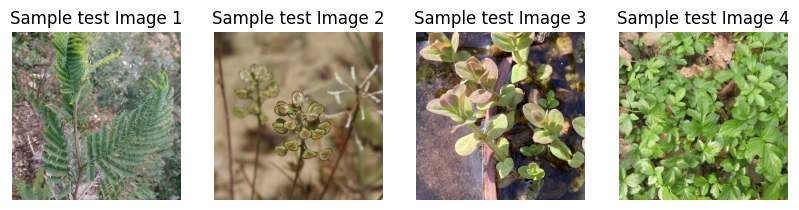

In [22]:
import random 
import matplotlib.pyplot as plt
from PIL import Image

image_paths = test_paths
random.shuffle(image_paths)

img_path = []

# Plot four sample images
plt.figure(figsize=(10, 8))
for i in range(4):
    image_path = image_paths[i]
    image = Image.open(image_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Sample test Image {i + 1}')
    img_path.append(image_path)

In [23]:
preds = model.predict(test_ds)["head"]

103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step


In [24]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{DATA_PATH}/test.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

id        X4       X11       X18       X26       X50     X3112
0  201238668  0.000872  0.353614  0.070342  0.270920  0.000537  0.303715
1  202310319  0.000170  0.193182  0.001898  0.658521  0.000271  0.145959
2  202604412  0.000096  0.030038  0.005554  0.642029  0.000091  0.322191
3  201353439  0.000017  0.996914  0.002034  0.000889  0.000022  0.000125
4  195351745  0.000005  0.000031  0.000009  0.000020  0.000006  0.999930